Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/391], Loss: 1.5009
Epoch [1/20], Step [200/391], Loss: 1.2732
Epoch [1/20], Step [300/391], Loss: 1.2338
Epoch [2/20], Step [100/391], Loss: 1.0291
Epoch [2/20], Step [200/391], Loss: 0.9884
Epoch [2/20], Step [300/391], Loss: 0.7977
Epoch [3/20], Step [100/391], Loss: 0.7912
Epoch [3/20], Step [200/391], Loss: 0.6711
Epoch [3/20], Step [300/391], Loss: 0.6405
Epoch [4/20], Step [100/391], Loss: 0.5140
Epoch [4/20], Step [200/391], Loss: 0.3500
Epoch [4/20], Step [300/391], Loss: 0.4890
Epoch [5/20], Step [100/391], Loss: 0.4991
Epoch [5/20], Step [200/391], Loss: 0.4055
Epoch [5/20], Step [300/391], Loss: 0.4391
Epoch [6/20], Step [100/391], Loss: 0.3553
Epoch [6/20], Step [200/391], Loss: 0.2802
Epoch [6/20], Step [300/391], Loss: 0.4538
Epoch [7/20], Step [100/391], Loss: 0.2896
Epoch [7/20], Step [200/391], Loss: 0.2205
Epoch [7/20], Step [300/391], Loss: 0.1626
Epoch [8/20], Step [1

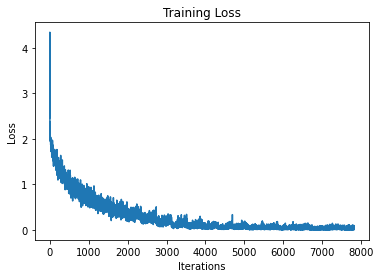

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Define ResNet block
class ResidualBlock(nn.Module):
    """
    A residual block that implements skip connections, a key feature of ResNet architectures.
    Skip connections help prevent vanishing gradients in deep networks by providing a direct path
    for gradients to flow backward.
    
    Args:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels
        stride (int): Stride for convolution operations, controls downsampling
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # First convolution layer with batch normalization
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolution layer with batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions when needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        """
        Forward pass of the residual block, combining the main path with the shortcut connection.
        """
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add the skip connection
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    """
    ResNet architecture implementation.
    This implementation follows the ResNet paper structure with configurable depth.
    
    Args:
        block: The basic building block (ResidualBlock in this case)
        num_blocks (list): Number of blocks in each layer
        num_classes (int): Number of output classes (default: 10 for CIFAR-10)
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Create the four main layers of ResNet
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Global average pooling and final fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Helper function to create a layer with specified number of residual blocks.
        
        Args:
            block: The block type to use
            out_channels (int): Number of output channels
            num_blocks (int): Number of blocks in this layer
            stride (int): Stride for the first block
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the entire ResNet model.
        Processes the input through all layers and returns the final output.
        """
        out = nn.ReLU()(self.bn1(self.conv1(x)))  # Initial convolution
        out = self.layer1(out)  # Process through each main layer
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Global average pooling
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)  # Final classification layer
        return out

def ResNet34():
    """
    Creates a ResNet-34 model instance.
    ResNet-34 has a specific configuration of [3, 4, 6, 3] blocks in its four main layers.
    """
    return ResNet(ResidualBlock, [3, 4, 6, 3])

# Create model instance
model = ResNet34()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create list to store losses
train_losses = []

# Training loop
epochs = 20  # Increase epochs for better results
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Append loss value to train_losses list
        train_losses.append(loss.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')

# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# Visualize training loss (optional)
# Assuming you have stored the loss values in a list during training
# ...

# Plot the loss
plt.plot(train_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
